In [ ]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import os
import zipfile

In [ ]:
data_dir ="/content/drive/MyDrive/flowers"

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4339 files belonging to 5 classes.
Using 3472 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4339 files belonging to 5 classes.
Using 867 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


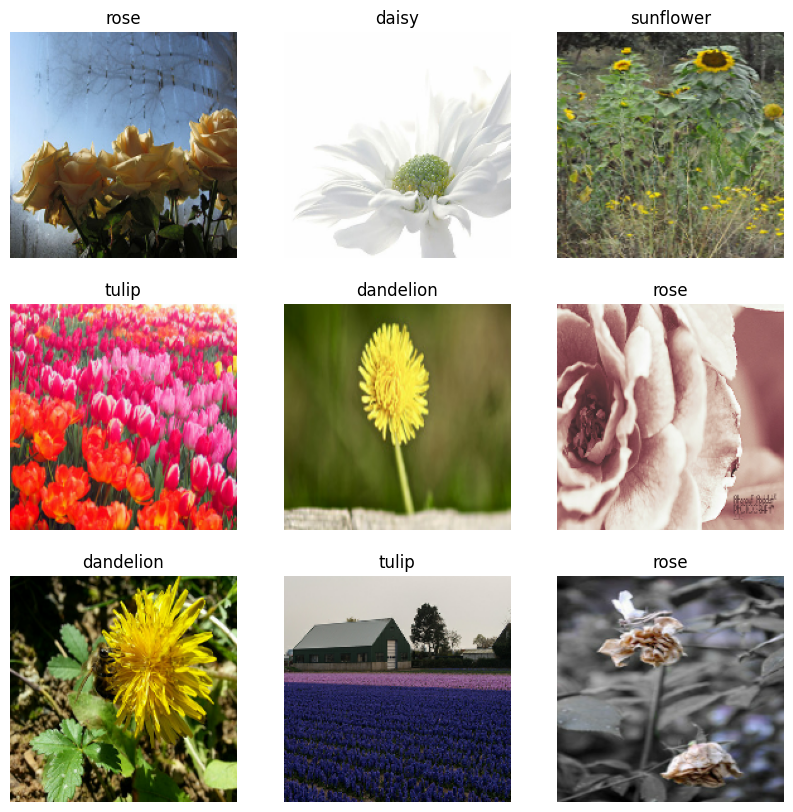

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9953816


In [ ]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


109/109 [==============================] - 207s 2s/step - loss: 1.2841 - accuracy: 0.4433 - val_loss: 1.1630 - val_accuracy: 0.5236
Epoch 2/10
109/109 [==============================] - 77s 703ms/step - loss: 1.0370 - accuracy: 0.5801 - val_loss: 0.9957 - val_accuracy: 0.6090
Epoch 3/10
109/109 [==============================] - 77s 704ms/step - loss: 0.8904 - accuracy: 0.6440 - val_loss: 0.9551 - val_accuracy: 0.6321
Epoch 4/10
109/109 [==============================] - 76s 696ms/step - loss: 0.7903 - accuracy: 0.6961 - val_loss: 0.8815 - val_accuracy: 0.6840
Epoch 5/10
109/109 [==============================] - 76s 699ms/step - loss: 0.6688 - accuracy: 0.7488 - val_loss: 0.8807 - val_accuracy: 0.6747
Epoch 6/10
109/109 [==============================] - 76s 700ms/step - loss: 0.5751 - accuracy: 0.7869 - val_loss: 0.9233 - val_accuracy: 0.6794
Epoch 7/10
109/109 [==============================] - 76s 700ms/step - loss: 0.4529 - accuracy: 0.8327 - val_loss: 1.0072 - val_accuracy: 0.671

KeyboardInterrupt: ignored

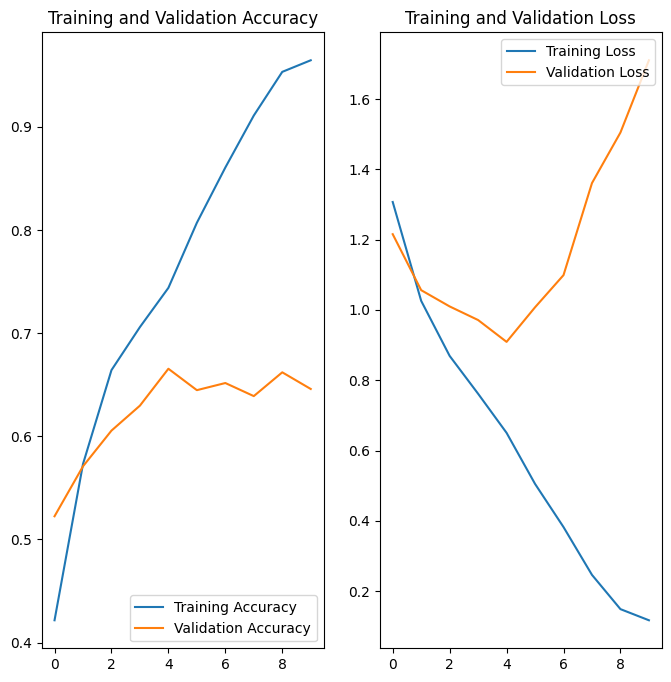

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

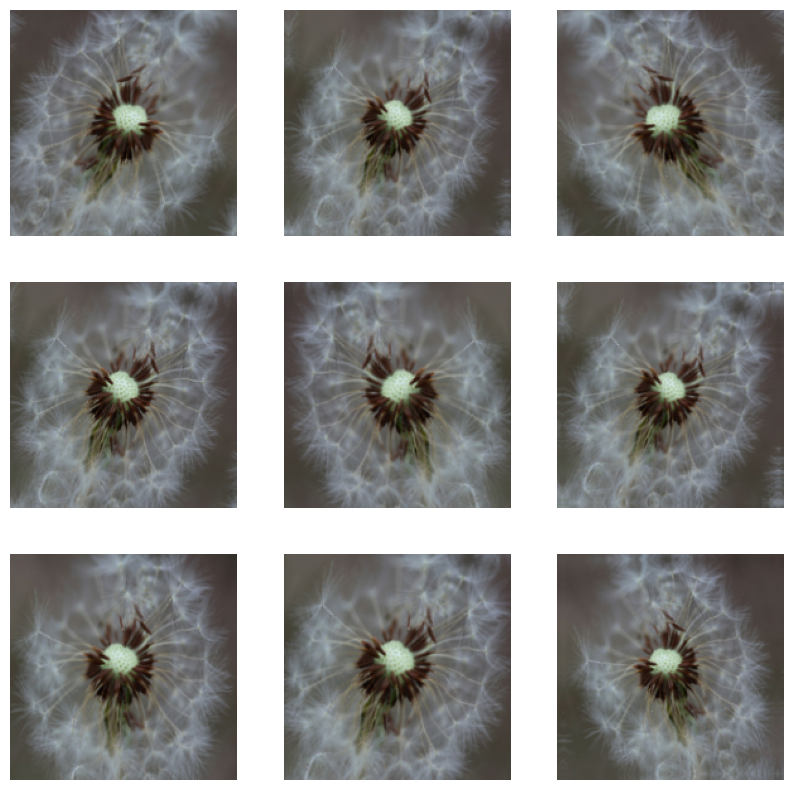

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
109/109 [==============================] - 7s 30ms/step - loss: 1.3326 - accuracy: 0.4283 - val_loss: 1.1128 - val_accuracy: 0.5606
Epoch 2/20
109/109 [==============================] - 3s 28ms/step - loss: 1.0783 - accuracy: 0.5726 - val_loss: 1.0300 - val_accuracy: 0.5882
Epoch 3/20
109/109 [==============================] - 3s 28ms/step - loss: 0.9789 - accuracy: 0.6086 - val_loss: 1.0255 - val_accuracy: 0.6021
Epoch 4/20
109/109 [==============================] - 3s 30ms/step - loss: 0.9307 - accuracy: 0.6374 - val_loss: 0.9889 - val_accuracy: 0.6159
Epoch 5/20
109/109 [==============================] - 3s 28ms/step - loss: 0.8919 - accuracy: 0.6512 - val_loss: 1.0472 - val_accuracy: 0.6148
Epoch 6/20
109/109 [==============================] - 3s 31ms/step - loss: 0.8560 - accuracy: 0.6714 - val_loss: 1.0119 - val_accuracy: 0.6159
Epoch 7/20
109/109 [==============================] - 3s 31ms/step - loss: 0.8289 - accuracy: 0.6878 - val_loss: 0.8943 - val_accuracy: 0.6551

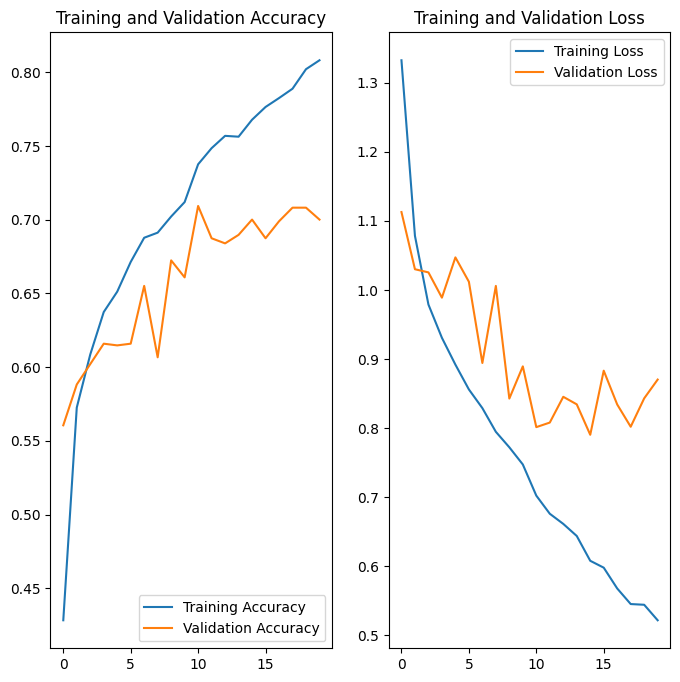

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np

28/28 [==============================] - 0s 8ms/step


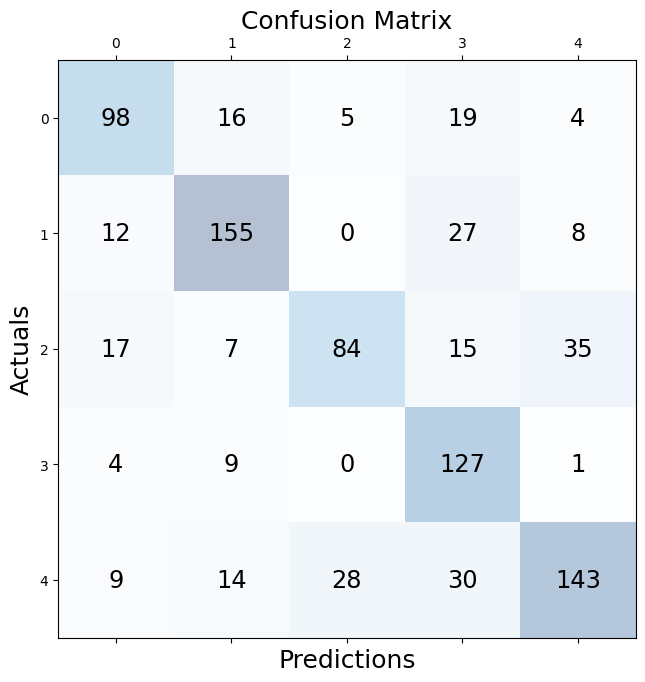

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
predictions = model.predict(val_ds)


# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Convert the softmax predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

import matplotlib. pyplot as plt
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
